# Step 2: Transfer Learning

In [1]:
%pwd

'/home/ubuntu'

In [2]:
import torch
useCuda = torch.cuda.is_available()
useCuda

True

## Download training dataset

In [3]:
# !wget https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip
# !unzip landmark_images.zip

## Load data

In [4]:

import numpy as np
import torch.cuda
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# images are 800*600
batchSize = 15
validPercent = 0.1

transformTrain = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
train_data = datasets.ImageFolder("landmark_images/train", transform = transformTrain)
test_data = datasets.ImageFolder("landmark_images/test", transform = transformTest)

# Sampler for train and validation
totalTrainSamples = len(train_data)
indices = list(range(totalTrainSamples))
np.random.shuffle(indices)
cutpoint = int(np.floor(totalTrainSamples * validPercent))
trainIdx, validIdx = indices[:cutpoint], indices[cutpoint:]

trainSampler = SubsetRandomSampler(trainIdx)
validSampler = SubsetRandomSampler(validIdx)

# Data loader
trainDataLoader = DataLoader(train_data, sampler=trainSampler, batch_size=batchSize)
validDataLoader = DataLoader(train_data, sampler=validSampler, batch_size=batchSize)
testDataLoader = DataLoader(test_data, batch_size=batchSize)

loaders_transfer = {'train': trainDataLoader, 'valid': validDataLoader, 'test': testDataLoader}

## Model design

In [5]:

from torch import optim, nn

criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    # return optim.SGD(model.parameters(), lr=0.002)
    # return optim.SGD(model.parameters(), lr=0.0005, momentum=0.85)
    return optim.AdamW(model.classifier.parameters(), lr=0.00001)

    # optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

    # return optimizer


In [6]:

from torchvision import models
import torch

## TODO: Specify model architecture
# (classifier): Sequential(
#     (0): Linear(in_features=25088, out_features=4096, bias=True)
#     (1): ReLU(inplace=True)
#     (2): Dropout(p=0.5, inplace=False)
#     (3): Linear(in_features=4096, out_features=4096, bias=True)
#     (4): ReLU(inplace=True)
#     (5): Dropout(p=0.5, inplace=False)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)

model_transfer = models.vgg19(pretrained=True)

# freeze weights of feature layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

dropout = nn.Dropout(0.2)
relu = nn.ReLU(inplace=True)

model_transfer.classifier.add_module("7", relu)
model_transfer.classifier.add_module("8", dropout)
model_transfer.classifier.add_module("9", nn.Linear(1000,50))

# model_transfer.classifier = nn.Sequential(
#     nn.Linear(in_features=25088, out_features=4096, bias=True),
#     relu,
#     dropout,
#     nn.Linear(in_features=4096, out_features=1024, bias=True),
#     relu,
#     dropout,
#     nn.Linear(in_features=1024, out_features=500, bias=True),
#     relu,
#     dropout,
#     nn.Linear(in_features=500, out_features=200, bias=True),
#     relu,
#     dropout,
#     nn.Linear(in_features=200, out_features=50, bias=True),
# )

#-#-# Do NOT modify the code below this line. #-#-#
if torch.cuda.is_available():
    model_transfer = model_transfer.cuda()

model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Train and Validation

In [8]:



def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    # scheduler = StepLR(optimizer, 10, 0.1)

    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # train_loss += loss.item() * data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            loss.backward()
            optimizer.step()

        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()

        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss
            o = model(data)
            loss = criterion(o, target)
            # valid_loss += loss.item() * data.size(0)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))

        # average
        # train_loss /= len(loaders['train'].sampler)
        # valid_loss /= len(loaders['valid'].sampler)

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
        ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # scheduler.step()
    return model

In [ ]:

def transferWeightInit(m):
    if isinstance(m,  nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.normal_(m.bias)


model_transfer.apply(transferWeightInit)

num_epochs = 60

# train the model
useCuda = torch.cuda.is_available()
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, useCuda, 'model_transfer.pt')


## Continue training

In [19]:
# continue training
model_transfer.load_state_dict(torch.load('stepTwo59.pt'))

num_epochs = 30

# train the model
useCuda = torch.cuda.is_available()
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, useCuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.655570 	Validation Loss: 1.948434
Validation loss decreased (inf --> 1.948434).  Saving model ...
Epoch: 2 	Training Loss: 2.283719 	Validation Loss: 1.940966
Validation loss decreased (1.948434 --> 1.940966).  Saving model ...
Epoch: 3 	Training Loss: 2.400288 	Validation Loss: 1.941749
Epoch: 4 	Training Loss: 2.389556 	Validation Loss: 1.929356
Validation loss decreased (1.940966 --> 1.929356).  Saving model ...
Epoch: 5 	Training Loss: 2.351932 	Validation Loss: 1.923018
Validation loss decreased (1.929356 --> 1.923018).  Saving model ...
Epoch: 6 	Training Loss: 2.208486 	Validation Loss: 1.915749
Validation loss decreased (1.923018 --> 1.915749).  Saving model ...
Epoch: 7 	Training Loss: 2.337645 	Validation Loss: 1.902894
Validation loss decreased (1.915749 --> 1.902894).  Saving model ...
Epoch: 8 	Training Loss: 2.128482 	Validation Loss: 1.866488
Validation loss decreased (1.902894 --> 1.866488).  Saving model ...
Epoch: 9 	Training Loss: 2.211186 

In [20]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

## Testing the model

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [21]:
# test(loaders_transfer, model_transfer, criterion_transfer, torch.cuda.is_available())
test(loaders_transfer, model_transfer, criterion_transfer, useCuda)


Test Loss: 1.609857


Test Accuracy: 60% (756/1250)


## Predict

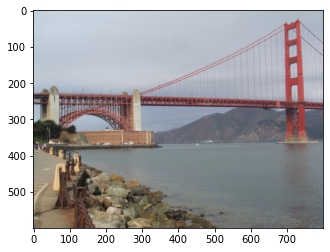

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline

imgPath = 'landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg'

img = Image.open(imgPath).convert('RGB')
plt.imshow(np.array(img))

In [ ]:
trainDataLoader.dataset.classes

In [23]:
transformTrain = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])

inputArray = transformTrain(img)
inputArray = torch.unsqueeze(inputArray, 0).cuda()

model_transfer.eval()
output = model_transfer(inputArray)
score, idx = torch.topk(output, 5)

result = []
for i in idx[0]:
    result.append(trainDataLoader.dataset.classes[i].split(".")[1])

# print(score)
# print(idx)

result

['Brooklyn_Bridge',
 'Sydney_Harbour_Bridge',
 'Golden_Gate_Bridge',
 'Forth_Bridge',
 'Eiffel_Tower']

# Step 3: Write Own Prediction

In [ ]:
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

    inputArray = transform(img)

    if torch.cuda.is_available():
        inputArray = torch.unsqueeze(inputArray, 0).cuda()
    else:
        inputArray = torch.unsqueeze(inputArray, 0)

    model_transfer.eval()
    output = model_transfer(inputArray)
    score, idx = torch.topk(output, k)

    result = []
    for i in idx[0]:
        result.append(trainDataLoader.dataset.classes[i].split(".")[1])


    plt.imshow(img)
    msg = "Is this "
    for idx, loc in enumerate(result):
        if idx == len(result) - 1:
            msg += "or "
            msg += loc
            msg += "?"
            break

        msg += loc
        msg += ", "
    print(msg)

# test on a sample image
predict_landmarks('../landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)
predict_landmarks('../landmark_images/test/16.Eiffel_Tower/3828627c8730f160.jpg', 5)
predict_landmarks('../landmark_images/test/24.Soreq_Cave/18dbbad48a83a742.jpg', 5)
predict_landmarks('../landmark_images/test/37.Atomium/5ecb74282baee5aa.jpg', 5)
predict_landmarks('../landmark_images/test/41.Machu_Picchu/4336abf3179202f2.jpg', 5)
